# GAE

In [1]:
import pandas as pd 
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.nn import GCNConv, GAE
from torch.nn import Module
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

model: GAE
optimizer: torch.optim.Adam

class GCNEncoder(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 70)
        self.conv2 = GCNConv(70, 50)
        self.conv3 = GCNConv(50, out_channels)

    def forward(self, x, edge_index, edge_weight, batch=None):
        x = F.tanh(self.conv1(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv2(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv3(x, edge_index=edge_index, edge_weight=edge_weight))
        return x

def remove_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].reset_index(drop=True)

    return df

def data_standardization(df: pd.DataFrame, target: str):
    scaler = MinMaxScaler()

    df[target + '_original'] = df[target]
    scaler = scaler.fit(df[[target]])
    df[target] = scaler.transform(df[[target]])

    return df

def read_train_data(data: pd.DataFrame):
    training_dataset = []

    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except:
            pass
    
    input_dim : int = training_dataset[0].x.shape[1]

    return training_dataset, input_dim

def create_train_and_validation_dataset(training_dataset: list) -> tuple[list, list]:
    print(f'Spliting data into training dataset and validation dataset.')

    dist = 0.90

    dataset_len = len(training_dataset)

    train_dataset = training_dataset[:int(dataset_len*dist)]
    val_dataset = training_dataset[int(dataset_len*dist):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')

    return train_dataset, val_dataset

def create_batches(train_dataset: list, val_dataset: list, batch_size: int) -> tuple[list, list]:
    print(f'Creating batches.')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

def train_model(train_loader):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
        batch_size = data.y.size(0)  # Number of samples in the batch
        total_loss += loss.item() * batch_size  # Weight loss by batch size
        total_samples += batch_size

        return total_loss / total_samples if total_samples > 0 else 0
    
def validate_model(val_loader):
    model.eval()
    total_val_loss = 0
    total_val_samples = 0
    all_pos_edges, all_neg_edges, all_z = [], [], []
    
    with torch.no_grad():
        for data in val_loader:
            z = model.encode(data.x, data.edge_index, data.edge_weight)
            loss = model.recon_loss(z, data.edge_index)
            batch_size = data.num_nodes  # Use num_nodes for per-node loss weighting
            total_val_loss += loss.item() * batch_size
            total_val_samples += batch_size
            
            # For AUC: Collect for aggregated evaluation
            all_z.append(z)
            all_pos_edges.append(data.edge_index)
            neg_edge_index = negative_sampling(data.edge_index, z.size(0))
            all_neg_edges.append(neg_edge_index)
    
    avg_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else 0
    
    # Aggregated AUC
    z_cat = torch.cat(all_z, dim=0)
    pos_cat = torch.cat(all_pos_edges, dim=1)
    neg_cat = torch.cat(all_neg_edges, dim=1)
    auc, ap = model.test(z_cat, pos_cat, neg_cat)
    
    return avg_val_loss, auc, ap

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')

df = remove_outliers(df, 'static_polarizability')
df = data_standardization(df, 'static_polarizability')

traning_dataset, input_dim = read_train_data(df)
train_dataset, val_dataset = create_train_and_validation_dataset(traning_dataset)
train_loader, val_loader = create_batches(train_dataset, val_dataset, 16)


Reading training data.


25638it [00:08, 3139.25it/s]

Spliting data into training dataset and validation dataset.
Number of training graphs: 22739
Number of validation graphs: 2527
Creating batches.


In [4]:
encoder = GCNEncoder(input_dim, 40)
model = GAE(encoder=encoder)  # Uses default InnerProductDecoder
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
epochs = 300
best_val_loss = float('inf')
patience = 50
counter = 0

metrics = pd.DataFrame()

for epoch in range(epochs):
    train_loss = train_model(train_loader)  # Fix to accumulate over all batches
    val_loss, val_auc, ap = validate_model(val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {ap:.4f}')
    metrics = pd.concat([metrics, pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss, 'val_auc': val_auc, 'val_ap': ap}, index=[0])])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model, 'best_gae_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1, Train Loss: 1.6608, Val Loss: 1.6612, Val AUC: 0.6544, Val AP: 0.6552
Epoch 2, Train Loss: 1.6570, Val Loss: 1.6337, Val AUC: 0.6448, Val AP: 0.6497
Epoch 3, Train Loss: 1.6813, Val Loss: 1.6030, Val AUC: 0.6565, Val AP: 0.6530
Epoch 4, Train Loss: 1.5590, Val Loss: 1.5746, Val AUC: 0.6511, Val AP: 0.6473
Epoch 5, Train Loss: 1.6021, Val Loss: 1.5502, Val AUC: 0.6460, Val AP: 0.6432
Epoch 6, Train Loss: 1.5889, Val Loss: 1.5235, Val AUC: 0.6868, Val AP: 0.6868
Epoch 7, Train Loss: 1.5411, Val Loss: 1.4973, Val AUC: 0.7018, Val AP: 0.6886
Epoch 8, Train Loss: 1.4856, Val Loss: 1.4759, Val AUC: 0.6691, Val AP: 0.6652
Epoch 9, Train Loss: 1.5315, Val Loss: 1.4561, Val AUC: 0.6682, Val AP: 0.6570
Epoch 10, Train Loss: 1.4837, Val Loss: 1.4291, Val AUC: 0.6761, Val AP: 0.6757
Epoch 11, Train Loss: 1.4263, Val Loss: 1.4123, Val AUC: 0.6886, Val AP: 0.6821
Epoch 12, Train Loss: 1.4228, Val Loss: 1.3953, Val AUC: 0.6901, Val AP: 0.6824
Epoch 13, Train Loss: 1.3928, Val Loss: 1.3782, V

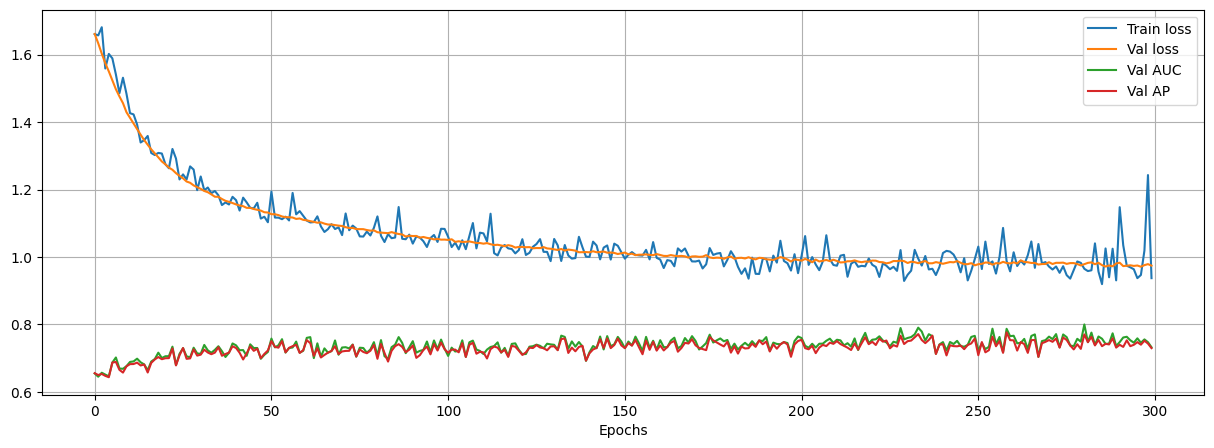

In [10]:
import matplotlib.pyplot as plt

metrics = metrics.reset_index(drop=True)

plt.figure(figsize=(15,5))
plt.plot(metrics.index, metrics['train_loss'], label='Train loss')
plt.plot(metrics.index, metrics['val_loss'], label='Val loss')
plt.plot(metrics.index, metrics['val_auc'], label='Val AUC')
plt.plot(metrics.index, metrics['val_ap'], label='Val AP')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# VGAE

In [1]:
import pandas as pd 
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.nn import GCNConv, VGAE
from torch.nn import Module
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

model: VGAE
optimizer: torch.optim.Adam

class VariationalGCNEncoder(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 70)
        self.conv2 = GCNConv(70, 50)
        self.conv_mu = GCNConv(50, out_channels)
        self.conv_logstd = GCNConv(50, out_channels)

    def forward(self, x, edge_index, edge_weight, batch=None):
        x = F.tanh(self.conv1(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv2(x, edge_index=edge_index, edge_weight=edge_weight))
        mu = self.conv_mu(x, edge_index=edge_index, edge_weight=edge_weight)
        logstd = self.conv_logstd(x, edge_index=edge_index, edge_weight=edge_weight)
        return mu, logstd

def remove_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].reset_index(drop=True)

    return df

def data_standardization(df: pd.DataFrame, target: str):
    scaler = MinMaxScaler()

    df[target + '_original'] = df[target]
    scaler = scaler.fit(df[[target]])
    df[target] = scaler.transform(df[[target]])

    return df

def read_train_data(data: pd.DataFrame):
    training_dataset = []

    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except:
            pass
    
    input_dim : int = training_dataset[0].x.shape[1]

    return training_dataset, input_dim

def create_train_and_validation_dataset(training_dataset: list) -> tuple[list, list]:
    print(f'Spliting data into training dataset and validation dataset.')

    dist = 0.90

    dataset_len = len(training_dataset)

    train_dataset = training_dataset[:int(dataset_len*dist)]
    val_dataset = training_dataset[int(dataset_len*dist):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')

    return train_dataset, val_dataset

def create_batches(train_dataset: list, val_dataset: list, batch_size: int) -> tuple[list, list]:
    print(f'Creating batches.')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

def train_model(train_loader):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = model.recon_loss(z, data.edge_index)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()
        batch_size = data.y.size(0)  # Number of samples in the batch
        total_loss += loss.item() * batch_size  # Weight loss by batch size
        total_samples += batch_size

    return total_loss / total_samples if total_samples > 0 else 0
    
def validate_model(val_loader):
    model.eval()
    total_val_loss = 0
    total_val_samples = 0
    all_pos_edges, all_neg_edges, all_z = [], [], []
    
    with torch.no_grad():
        for data in val_loader:
            z = model.encode(data.x, data.edge_index, data.edge_weight)
            loss = model.recon_loss(z, data.edge_index)
            loss = loss + (1 / data.num_nodes) * model.kl_loss()
            batch_size = data.num_nodes  # Use num_nodes for per-node loss weighting
            total_val_loss += loss.item() * batch_size
            total_val_samples += batch_size
            
            # For AUC: Collect for aggregated evaluation
            all_z.append(z)
            all_pos_edges.append(data.edge_index)
            neg_edge_index = negative_sampling(data.edge_index, z.size(0))
            all_neg_edges.append(neg_edge_index)
    
    avg_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else 0
    
    # Aggregated AUC
    z_cat = torch.cat(all_z, dim=0)
    pos_cat = torch.cat(all_pos_edges, dim=1)
    neg_cat = torch.cat(all_neg_edges, dim=1)
    auc, ap = model.test(z_cat, pos_cat, neg_cat)
    
    return avg_val_loss, auc, ap

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')

df = remove_outliers(df, 'static_polarizability')
df = data_standardization(df, 'static_polarizability')

traning_dataset, input_dim = read_train_data(df)
train_dataset, val_dataset = create_train_and_validation_dataset(traning_dataset)
train_loader, val_loader = create_batches(train_dataset, val_dataset, 16)

encoder = VariationalGCNEncoder(input_dim, 40)
model = VGAE(encoder=encoder)  # Uses default InnerProductDecoder
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 300
best_val_loss = float('inf')
patience = 20
counter = 0

metrics = pd.DataFrame()

# for epoch in range(epochs):
#     train_loss = train_model(train_loader)
#     val_loss, val_auc, ap = validate_model(val_loader)
#     print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {ap:.4f}')
#     metrics = pd.concat([metrics, pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss, 'val_auc': val_auc, 'val_ap': ap}, index=[0])])
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#         torch.save(model, 'best_gae_model.pt')
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping")
#             break

Reading training data.


25638it [00:09, 2810.33it/s]

Spliting data into training dataset and validation dataset.
Number of training graphs: 22739
Number of validation graphs: 2527
Creating batches.


In [2]:
for i in val_loader:
    print(i)

DataBatch(x=[569, 75], edge_index=[2, 1154], edge_attr=[1154, 8], y=[16], edge_weight=[1154], mol_id=[16], chain_size=[16], batch=[569], ptr=[17])
DataBatch(x=[658, 75], edge_index=[2, 1340], edge_attr=[1340, 8], y=[16], edge_weight=[1340], mol_id=[16], chain_size=[16], batch=[658], ptr=[17])
DataBatch(x=[494, 75], edge_index=[2, 994], edge_attr=[994, 8], y=[16], edge_weight=[994], mol_id=[16], chain_size=[16], batch=[494], ptr=[17])
DataBatch(x=[613, 75], edge_index=[2, 1248], edge_attr=[1248, 8], y=[16], edge_weight=[1248], mol_id=[16], chain_size=[16], batch=[613], ptr=[17])
DataBatch(x=[633, 75], edge_index=[2, 1294], edge_attr=[1294, 8], y=[16], edge_weight=[1294], mol_id=[16], chain_size=[16], batch=[633], ptr=[17])
DataBatch(x=[601, 75], edge_index=[2, 1222], edge_attr=[1222, 8], y=[16], edge_weight=[1222], mol_id=[16], chain_size=[16], batch=[601], ptr=[17])
DataBatch(x=[606, 75], edge_index=[2, 1236], edge_attr=[1236, 8], y=[16], edge_weight=[1236], mol_id=[16], chain_size=[16

# Difussion model

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj

# class VariationalGCNEncoder(Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv1 = GCNConv(in_channels, 70, normalize=True)
#         self.conv2 = GCNConv(70, 50, normalize=True)
#         self.conv_mu = GCNConv(50, out_channels, normalize=True)
#         self.conv_logstd = GCNConv(50, out_channels, normalize=True)

#     def forward(self, x, edge_index, edge_weight, batch=None):
#         x = F.tanh(self.conv1(x, edge_index=edge_index, edge_weight=edge_weight))
#         x = F.tanh(self.conv2(x, edge_index=edge_index, edge_weight=edge_weight))
#         mu = self.conv_mu(x, edge_index=edge_index, edge_weight=edge_weight)
#         logstd = self.conv_logstd(x, edge_index=edge_index, edge_weight=edge_weight)
#         return mu, logstd

# class FeatureVAE(Module):
#     def __init__(self, encoder, out_channels, feature_dim):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder_conv1 = GCNConv(out_channels, 50, normalize=True)
#         self.decoder_conv2 = GCNConv(50, feature_dim, normalize=True)

#     def reparameterize(self, mu, logstd):
#         std = torch.exp(logstd)
#         eps = torch.randn_like(std)
#         return eps * std + mu

#     def encode(self, x, edge_index, edge_weight):
#         mu, logstd = self.encoder(x, edge_index, edge_weight)
#         z = self.reparameterize(mu, logstd)
#         return z, mu, logstd

#     def decode(self, z, edge_index, edge_weight):
#         x_recon = F.tanh(self.decoder_conv1(z, edge_index, edge_weight))
#         x_recon = self.decoder_conv2(x_recon, edge_index, edge_weight)
#         return x_recon

#     def recon_loss(self, z, x, edge_index, edge_weight):
#         recon_x = self.decode(z, edge_index, edge_weight)
#         return F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')

#     def kl_loss(self, mu, logstd):
#         return -0.5 * torch.sum(1 + 2 * logstd - mu**2 - torch.exp(2 * logstd))

def read_train_data(data: pd.DataFrame):
    training_dataset = []
    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except:
            pass
    input_dim = training_dataset[0].x.shape[1]
    return training_dataset, input_dim

def create_train_and_validation_dataset(training_dataset: list) -> tuple[list, list]:
    print(f'Spliting data into training dataset and validation dataset.')
    dist = 0.90
    dataset_len = len(training_dataset)
    train_dataset = training_dataset[:int(dataset_len*dist)]
    val_dataset = training_dataset[int(dataset_len*dist):]
    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')
    return train_dataset, val_dataset

def create_batches(train_dataset: list, val_dataset: list, batch_size: int) -> tuple[list, list]:
    print(f'Creating batches.')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')
df = df.head(4000)

training_dataset, input_dim = read_train_data(df)

Reading training data.


4000it [00:01, 3603.58it/s]


In [2]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, to_dense_adj

# Assume training_dataset is a list of Data objects

# Find max dimensions
max_nodes = max(data.x.size(0) for data in training_dataset)
max_edges = max(data.edge_index.size(1) for data in training_dataset)

for data in training_dataset:
    # Pad nodes
    pad_nodes = max_nodes - data.x.size(0)
    if pad_nodes > 0:
        data.x = torch.cat([data.x, torch.zeros((pad_nodes, data.x.size(1)), dtype=data.x.dtype)], dim=0)
    
    # Pad edges
    current_edges = data.edge_index.size(1)
    pad_edges = max_edges - current_edges
    if pad_edges > 0:
        dummy_node = max_nodes - 1
        dummy_edges = torch.tensor([[dummy_node] * pad_edges, [dummy_node] * pad_edges], dtype=data.edge_index.dtype)
        data.edge_index = torch.cat([data.edge_index, dummy_edges], dim=1)
        
        # Pad edge_attr
        data.edge_attr = torch.cat([data.edge_attr, torch.zeros((pad_edges, data.edge_attr.size(1)), dtype=data.edge_attr.dtype)], dim=0)
        
        # Pad edge_weight
        data.edge_weight = torch.cat([data.edge_weight, torch.zeros((pad_edges,), dtype=data.edge_weight.dtype)], dim=0)

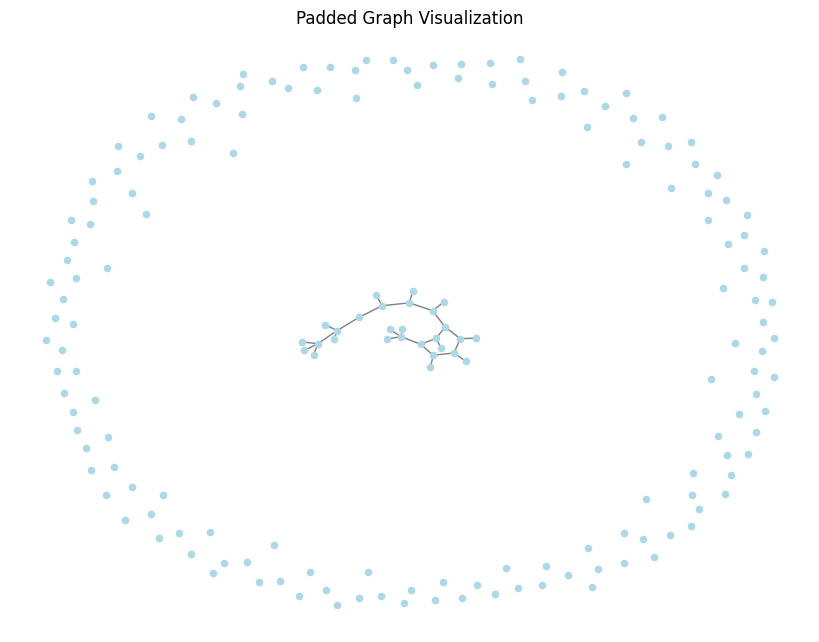

In [4]:
# Plot the first padded graph
if training_dataset:
    G = to_networkx(training_dataset[1000], to_undirected=True)
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color='lightblue', edge_color='gray', node_size=20)
    plt.title("Padded Graph Visualization")
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Step 2: Define Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps=250):
        super().__init__()
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        self.net = nn.Sequential(
            nn.Conv2d(1, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, 1, 3, padding=1),
        )
        self.time_embed = nn.Embedding(timesteps, input_dim * input_dim)

    def forward(self, x, t):
        t_embed = self.time_embed(t).view(-1, 1, self.input_dim, self.input_dim)
        x = x.unsqueeze(1)
        x = self.net(x + t_embed)
        return torch.sigmoid(x.squeeze(1))

    def get_noise(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def sample(self, batch_size, device):
        x = torch.randn(batch_size, self.input_dim, self.input_dim, device=device)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((batch_size,), t, dtype=torch.long, device=device)
            x = self.forward(x, t_tensor)
            if t > 0:
                noise = torch.randn_like(x)
                alpha_t = self.alpha[t][None, None, None]
                x = (x + (1 - alpha_t) * noise) / torch.sqrt(self.alpha[t])
        return (x > 0.5).float()

# Training and Evaluation
model = DiffusionModel(max_nodes, hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_diffusion(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            batch_size = x0.size(0)
            t = torch.randint(0, model.timesteps, (batch_size,), device=device)
            xt = model.get_noise(x0, t)  # Remove unused noise
            predicted_x0 = model(xt, t)
            loss = F.binary_cross_entropy(predicted_x0, x0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")

# Run training and evaluation
train_diffusion(epochs=20)
torch.save(model, "model_checkpoint.pt")

In [ ]:
def evaluate():
    model.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    total_bce_sampled = 0
    auc_scores_sampled = []
    ap_scores_sampled = []
    f1_scores_sampled = []

    with torch.no_grad():
        # Evaluate on test set (denoising)
        for batch in test_loader:
            x0 = batch[0].to(device)
            batch_size = x0.size(0)
            t = torch.randint(0, model.timesteps, (batch_size,), device=device)
            xt = model.get_noise(x0, t)
            pred_x0 = model(xt, t)
            
            # BCE Loss (denoising)
            bce_loss = F.binary_cross_entropy(pred_x0, x0)
            total_bce += bce_loss.item()

            # AUC, AP, F1 (denoising)
            pred_np = pred_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        # Evaluate generated samples
        sampled_matrices = model.sample(batch_size=16, device=device)
        for i in range(len(test_dataset)):
            x0 = test_dataset[i][0].to(device)
            pred_x0 = sampled_matrices[i % 16]  # Use sampled matrices
            bce_loss_sampled = F.binary_cross_entropy(pred_x0, x0)
            total_bce_sampled += bce_loss_sampled.item()

            pred_np = pred_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            auc_scores_sampled.append(roc_auc_score(true_np, pred_np))
            ap_scores_sampled.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.75).astype(int)
            f1_scores_sampled.append(f1_score(true_np, pred_binary))

    print(f"Denoising - Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Denoising - Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Denoising - Test AP: {np.mean(ap_scores):.4f}")
    print(f"Denoising - Test F1: {np.mean(f1_scores):.4f}")
    print(f"Sampled - Test BCE Loss: {total_bce_sampled / len(test_dataset):.4f}")
    print(f"Sampled - Test AUC: {np.mean(auc_scores_sampled):.4f}")
    print(f"Sampled - Test AP: {np.mean(ap_scores_sampled):.4f}")
    print(f"Sampled - Test F1: {np.mean(f1_scores_sampled):.4f}")
evaluate()

Denoising - Test BCE Loss: 0.0116
Denoising - Test AUC: 0.9307
Denoising - Test AP: 0.2073
Denoising - Test F1: 0.0400
Sampled - Test BCE Loss: 0.2527
Sampled - Test AUC: 0.5000
Sampled - Test AP: 0.0025
Sampled - Test F1: 0.0000


# VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')
df = df.head(4000)

training_dataset, input_dim = read_train_data(df)

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))  # 3200 for training
test_size = len(dataset) - train_size  # 800 for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

# Step 2: Simplified VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dim * input_dim * input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * input_dim),
            nn.Unflatten(1, (1, input_dim, input_dim)),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x.unsqueeze(1))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).squeeze(1)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(max_nodes, hidden_dim=40, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train_vae(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            optimizer.zero_grad()
            recon_x0, mu, logvar = model(x0)
            bce_loss = F.binary_cross_entropy(recon_x0, x0, reduction='sum') / x0.size(0)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x0.size(0)
            kl_weight = min(1.0, (epoch + 1) / 5.0)
            loss = bce_loss + kl_weight * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")

def evaluate():
    model.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            x0 = batch[0].to(device)
            recon_x0, _, _ = model(x0)
            bce_loss = F.binary_cross_entropy(recon_x0, x0, reduction='sum') / x0.size(0)
            total_bce += bce_loss.item()

            pred_np = recon_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            all_preds.extend(pred_np)
            all_trues.extend(true_np)
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        thresholds = np.arange(0.1, 0.9, 0.05)
        f1_scores_threshold = []
        for thresh in thresholds:
            pred_binary = (np.array(all_preds) > thresh).astype(int)
            f1 = f1_score(np.array(all_trues), pred_binary)
            f1_scores_threshold.append(f1)

        optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
        optimal_f1 = max(f1_scores_threshold)

    print(f"Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Test AP: {np.mean(ap_scores):.4f}")
    print(f"Test F1 (0.5): {np.mean(f1_scores):.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.2f}, F1: {optimal_f1:.4f}")

# Run training and evaluation
train_vae(epochs=150)
torch.save(model, "vae_checkpoint.pt")
evaluate()

/Users/gabriel/Documents/Apps/PolyGraphPy/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Loss=21377.7360
Epoch 2: Loss=20710.7844
Epoch 3: Loss=20205.4566
Epoch 4: Loss=19668.1159
Epoch 5: Loss=19100.3750
Epoch 6: Loss=18447.8770
Epoch 7: Loss=17739.0683
Epoch 8: Loss=16945.2721
Epoch 9: Loss=16125.2967
Epoch 10: Loss=15138.8286
Epoch 11: Loss=14054.4477
Epoch 12: Loss=13011.0747
Epoch 13: Loss=11897.4267
Epoch 14: Loss=10566.7647
Epoch 15: Loss=9483.6661
Epoch 16: Loss=8419.1539
Epoch 17: Loss=7291.4117
Epoch 18: Loss=6289.4098
Epoch 19: Loss=5238.9226
Epoch 20: Loss=4615.8782
Test BCE Loss: 4084.0401
Test AUC: 0.7218
Test AP: 0.2793
Test F1 (0.5): 0.3331
Optimal Threshold: 0.55, F1: 0.3915


# AE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))  # 3200 for training
test_size = len(dataset) - train_size  # 800 for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

# Step 2: Define Deterministic Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dim * input_dim * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * input_dim),
            nn.Unflatten(1, (1, input_dim, input_dim)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        z = self.encoder(x)
        return self.decoder(z).squeeze(1)

# Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(max_nodes, hidden_dim=16, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train_ae(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            optimizer.zero_grad()
            recon_x0 = model(x0)
            loss = F.binary_cross_entropy(recon_x0, x0, reduction='sum') / x0.size(0)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")

def evaluate():
    model.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            x0 = batch[0].to(device)
            recon_x0 = model(x0)
            bce_loss = F.binary_cross_entropy(recon_x0, x0, reduction='sum') / x0.size(0)
            total_bce += bce_loss.item()

            pred_np = recon_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            all_preds.extend(pred_np)
            all_trues.extend(true_np)
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        thresholds = np.arange(0.1, 0.9, 0.05)
        f1_scores_threshold = []
        for thresh in thresholds:
            pred_binary = (np.array(all_preds) > thresh).astype(int)
            f1 = f1_score(np.array(all_trues), pred_binary)
            f1_scores_threshold.append(f1)

        optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
        optimal_f1 = max(f1_scores_threshold)

    print(f"Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Test AP: {np.mean(ap_scores):.4f}")
    print(f"Test F1 (0.5): {np.mean(f1_scores):.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.2f}, F1: {optimal_f1:.4f}")

# Run training and evaluation
train_ae(epochs=20)
torch.save(model.state_dict(), "ae_checkpoint.pt")
evaluate()

# GAN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))  # 3200 for training
test_size = len(dataset) - train_size  # 800 for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Step 2: Define GAN
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, hidden_dim),  # Noise input size: 100
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * input_dim * input_dim),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dim, input_dim, input_dim)),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z).squeeze(1)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dim * input_dim * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x.unsqueeze(1))

# Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(max_nodes, hidden_dim=32).to(device)
discriminator = Discriminator(max_nodes, hidden_dim=32).to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

def train_gan(epochs=20):
    for epoch in range(epochs):
        g_loss_total = 0
        d_loss_total = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            batch_size = x0.size(0)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            z = torch.randn(batch_size, 100, device=device)
            fake_x0 = generator(z)
            d_real = discriminator(x0)
            d_fake = discriminator(fake_x0.detach())
            d_loss = F.binary_cross_entropy(d_real, real_labels) + F.binary_cross_entropy(d_fake, fake_labels)
            d_loss.backward()
            d_optimizer.step()
            d_loss_total += d_loss.item()

            # Train Generator
            g_optimizer.zero_grad()
            fake_x0 = generator(z)
            d_fake = discriminator(fake_x0)
            g_loss = F.binary_cross_entropy(d_fake, real_labels)
            g_loss.backward()
            g_optimizer.step()
            g_loss_total += g_loss.item()

        print(f"Epoch {epoch+1}: G Loss={g_loss_total / len(train_loader):.4f}, D Loss={d_loss_total / len(train_loader):.4f}")

def evaluate():
    generator.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            x0 = batch[0].to(device)
            batch_size = x0.size(0)
            z = torch.randn(batch_size, 100, device=device)
            pred_x0 = generator(z)
            bce_loss = F.binary_cross_entropy(pred_x0, x0)
            total_bce += bce_loss.item()

            pred_np = pred_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            all_preds.extend(pred_np)
            all_trues.extend(true_np)
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        thresholds = np.arange(0.1, 0.9, 0.05)
        f1_scores_threshold = []
        for thresh in thresholds:
            pred_binary = (np.array(all_preds) > thresh).astype(int)
            f1 = f1_score(np.array(all_trues), pred_binary)
            f1_scores_threshold.append(f1)

        optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
        optimal_f1 = max(f1_scores_threshold)

    print(f"Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Test AP: {np.mean(ap_scores):.4f}")
    print(f"Test F1 (0.5): {np.mean(f1_scores):.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.2f}, F1: {optimal_f1:.4f}")

# Run training and evaluation
train_gan(epochs=20)
torch.save(generator, "gan_generator_checkpoint.pt")
evaluate()

# Autoregressive Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))  # 3200 for training
test_size = len(dataset) - train_size  # 800 for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Step 2: Define Autoregressive Model
class AutoregressiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.rnn = nn.LSTM(input_dim * input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim * input_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten to [batch, input_dim * input_dim]
        seq = torch.zeros(batch_size, self.input_dim * self.input_dim, device=x.device)
        output = []
        hidden = None
        for t in range(self.input_dim * self.input_dim):
            inp = seq[:, :t+1] if t > 0 else torch.zeros(batch_size, 1, device=x.device)
            out, hidden = self.rnn(inp.unsqueeze(1), hidden)
            pred = self.sigmoid(self.fc(out.squeeze(1)))
            output.append(pred[:, t:t+1])
            seq[:, t] = x[:, t]  # Use ground truth during training
        return torch.cat(output, dim=1).view(batch_size, self.input_dim, self.input_dim)

    def sample(self, batch_size, device):
        self.eval()
        seq = torch.zeros(batch_size, self.input_dim * self.input_dim, device=device)
        hidden = None
        with torch.no_grad():
            for t in range(self.input_dim * self.input_dim):
                inp = seq[:, :t+1] if t > 0 else torch.zeros(batch_size, 1, device=device)
                out, hidden = self.rnn(inp.unsqueeze(1), hidden)
                pred = self.sigmoid(self.fc(out.squeeze(1)))
                seq[:, t] = (pred[:, t] > 0.5).float()
        return seq.view(batch_size, self.input_dim, self.input_dim)

# Training and Evaluation
model = AutoregressiveModel(max_nodes, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_autoregressive(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            optimizer.zero_grad()
            pred_x0 = model(x0)
            loss = F.binary_cross_entropy(pred_x0, x0)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")

def evaluate():
    model.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            x0 = batch[0].to(device)
            pred_x0 = model(x0)
            bce_loss = F.binary_cross_entropy(pred_x0, x0)
            total_bce += bce_loss.item()

            pred_np = pred_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            all_preds.extend(pred_np)
            all_trues.extend(true_np)
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        thresholds = np.arange(0.1, 0.9, 0.05)
        f1_scores_threshold = []
        for thresh in thresholds:
            pred_binary = (np.array(all_preds) > thresh).astype(int)
            f1 = f1_score(np.array(all_trues), pred_binary)
            f1_scores_threshold.append(f1)

        optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
        optimal_f1 = max(f1_scores_threshold)

    print(f"Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Test AP: {np.mean(ap_scores):.4f}")
    print(f"Test F1 (0.5): {np.mean(f1_scores):.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.2f}, F1: {optimal_f1:.4f}")

# Run training and evaluation
train_autoregressive(epochs=20)
torch.save(model, "autoregressive_checkpoint.pt")
evaluate()

# Flow

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

# Step 1: Generate padded connectivity matrices
def get_padded_connectivity_matrices(training_dataset):
    max_nodes = max(data.x.size(0) for data in training_dataset)
    connectivity_matrices = []
    
    for data in training_dataset:
        adj_matrix = to_dense_adj(data.edge_index, edge_attr=data.edge_weight).squeeze(0)
        adj_matrix = (adj_matrix > 0).float()
        pad_size = max_nodes - adj_matrix.size(0)
        if pad_size > 0:
            adj_matrix = F.pad(adj_matrix, (0, pad_size, 0, pad_size), value=0)
        connectivity_matrices.append(adj_matrix)
    
    return torch.stack(connectivity_matrices), max_nodes

connectivity_matrices, max_nodes = get_padded_connectivity_matrices(training_dataset)
dataset = TensorDataset(connectivity_matrices)
train_size = int(0.8 * len(dataset))  # 3200 for training
test_size = len(dataset) - train_size  # 800 for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Step 2: Define RealNVP-based Normalizing Flow
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows=4):
        super().__init__()
        self.input_dim = input_dim
        self.num_flows = num_flows
        self.nets = nn.ModuleList()
        self.nett = nn.ModuleList()

        # Define coupling layers
        for _ in range(num_flows):
            net_s = nn.Sequential(
                nn.Conv2d(1, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, 1, 3, padding=1)
            )
            net_t = nn.Sequential(
                nn.Conv2d(1, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, 1, 3, padding=1)
            )
            self.nets.append(net_s)
            self.nett.append(net_t)

        # Binary mask for coupling (alternate rows/columns)
        self.mask = torch.ones(input_dim, input_dim)
        self.mask[::2] = 0  # Checkerboard pattern

    def forward(self, x):
        log_det = torch.zeros(x.size(0), device=x.device)
        z = x.unsqueeze(1)  # [batch, 1, input_dim, input_dim]
        for i in range(self.num_flows):
            mask = self.mask if i % 2 == 0 else 1 - self.mask
            mask = mask.to(x.device)
            z_masked = z * mask
            s = self.nets[i](z_masked) * (1 - mask)
            t = self.nett[i](z_masked) * (1 - mask)
            z = z_masked + (1 - mask) * (z * torch.exp(s) + t)
            log_det += s.squeeze(1).sum(dim=(1, 2))
        return z.squeeze(1), log_det

    def inverse(self, z):
        x = z.unsqueeze(1)
        for i in reversed(range(self.num_flows)):
            mask = self.mask if i % 2 == 0 else 1 - self.mask
            mask = mask.to(z.device)
            x_masked = x * mask
            s = self.nets[i](x_masked) * (1 - mask)
            t = self.nett[i](x_masked) * (1 - mask)
            x = (x - t) * torch.exp(-s) * (1 - mask) + x_masked
        return x.squeeze(1)

    def sample(self, batch_size, device):
        z = torch.randn(batch_size, self.input_dim, self.input_dim, device=device)
        x = self.inverse(z)
        return torch.sigmoid(x)  # Apply sigmoid for binary output

# Training and Evaluation
model = RealNVP(max_nodes, hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_flow(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x0 = batch[0].to(device)
            optimizer.zero_grad()
            z, log_det = model(x0)
            # Negative log-likelihood loss (assuming Gaussian prior)
            log_pz = -0.5 * torch.sum(z**2, dim=(1, 2))
            loss = -(log_pz + log_det).mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")

def evaluate():
    model.eval()
    total_bce = 0
    auc_scores = []
    ap_scores = []
    f1_scores = []
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for batch in test_loader:
            x0 = batch[0].to(device)
            pred_x0 = model.sample(x0.size(0), device)
            bce_loss = F.binary_cross_entropy(pred_x0, x0)
            total_bce += bce_loss.item()

            pred_np = pred_x0.cpu().numpy().flatten()
            true_np = x0.cpu().numpy().flatten()
            all_preds.extend(pred_np)
            all_trues.extend(true_np)
            auc_scores.append(roc_auc_score(true_np, pred_np))
            ap_scores.append(average_precision_score(true_np, pred_np))
            pred_binary = (pred_np > 0.5).astype(int)
            f1_scores.append(f1_score(true_np, pred_binary))

        thresholds = np.arange(0.1, 0.9, 0.05)
        f1_scores_threshold = []
        for thresh in thresholds:
            pred_binary = (np.array(all_preds) > thresh).astype(int)
            f1 = f1_score(np.array(all_trues), pred_binary)
            f1_scores_threshold.append(f1)

        optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
        optimal_f1 = max(f1_scores_threshold)

    print(f"Test BCE Loss: {total_bce / len(test_loader):.4f}")
    print(f"Test AUC: {np.mean(auc_scores):.4f}")
    print(f"Test AP: {np.mean(ap_scores):.4f}")
    print(f"Test F1 (0.5): {np.mean(f1_scores):.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.2f}, F1: {optimal_f1:.4f}")

# Run training and evaluation
train_flow(epochs=20)
torch.save(model, "flow_checkpoint.pt")
evaluate()